### **Initialization**

*Setting up Fast.ai Environment.*

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


**Downloading the Dependencies**

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

*Since, Fastai has its own dataset for Image Segmentation. I will import the Data from Fastai Dataset.*

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/"labels"
path_img = path/"images"

**Subset Classes**

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent) + 'annot') / x.name

# codes = array(["Sky", "Building", "Pole", "Road", "Sidewalk", "Tree", "Sign", "Fence", "Car", "Pedestrian", "Cyclist", "Void"])

# src = (SegmentationItemList.from_folder(path)
#       .split_by_folder(valid="val")
#       .label_from_func(get_y_fn, classes=codes))

# bs = 8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

### **Data**

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f02520.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07987.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03060.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_06960_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03540_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01320_P.png')]

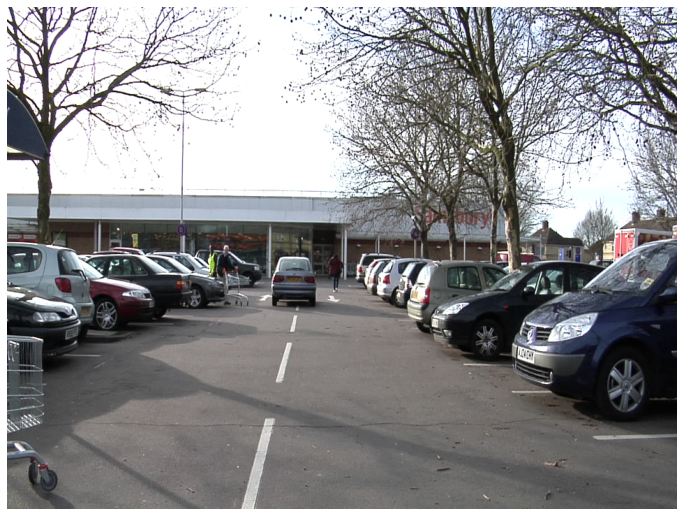

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(12, 10))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

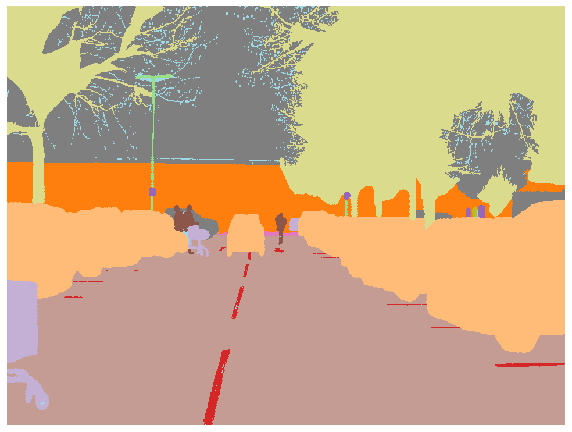

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10, 9), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          [26, 26, 26,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/"codes.txt", dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### **Preparing the Datasets.**

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200:
  bs = 8
else:
  bs = 4
print(f"Using bs={bs}, have {free} MB of GPU RAM free.")

Using bs=8, have 15068 MB of GPU RAM free.


In [14]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

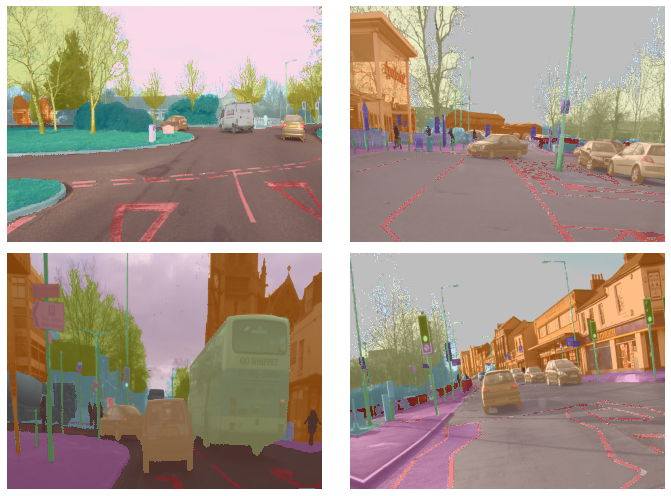

In [16]:
data.show_batch(2, figsize=(10, 7))

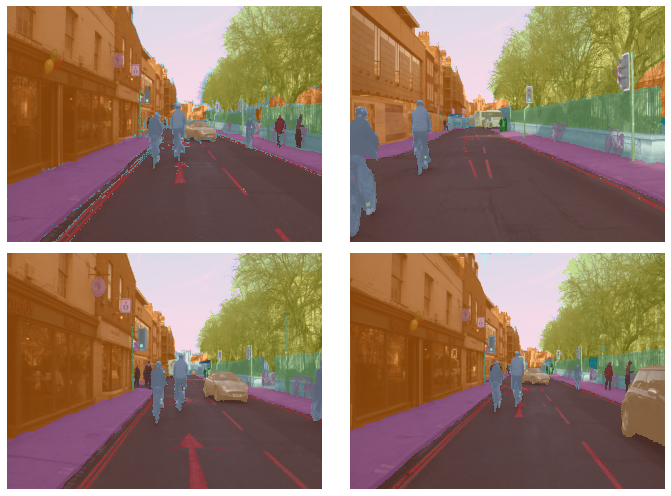

In [17]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

## **Model Generation**

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id["Void"]

def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [19]:
metrics = acc_camvid

In [20]:
wd = 1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


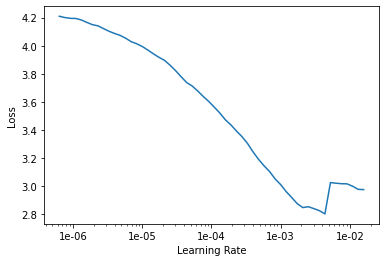

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr = 1e-03

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.652436,1.191375,0.721819,01:29
1,1.052815,0.769368,0.817025,01:26
2,0.791912,0.593721,0.847678,01:26
3,0.662756,0.531996,0.857784,01:26
4,0.584997,0.495972,0.863424,01:26
5,0.570051,0.507032,0.862167,01:26
6,0.560840,0.480083,0.876070,01:25
7,0.527898,0.418804,0.883805,01:25
8,0.483520,0.410548,0.882820,01:25
9,0.428637,0.333704,0.902852,01:25


In [25]:
learn.save("stage-1")

In [26]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

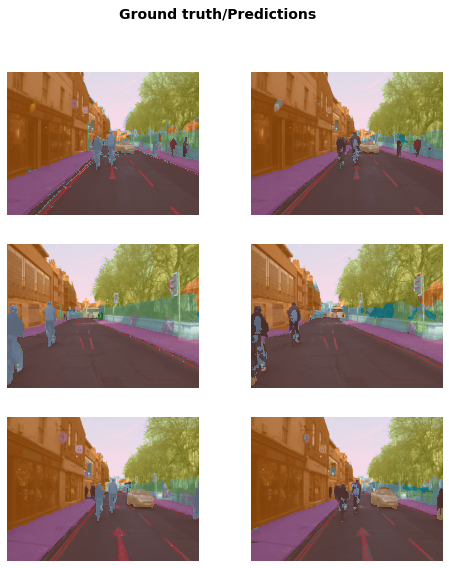

In [27]:
learn.show_results(rows=3, figsize=(8, 9))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


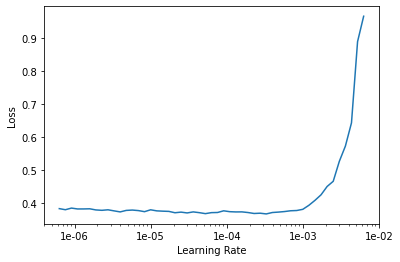

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lrs = slice(1e-05, lr/5)

In [31]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.361866,0.306826,0.912762,01:29
1,0.352623,0.302042,0.915178,01:29
2,0.342992,0.291775,0.920872,01:29
3,0.328295,0.300567,0.913681,01:29
4,0.318070,0.276033,0.923815,01:29
5,0.310046,0.299337,0.914175,01:29
6,0.297085,0.286710,0.919097,01:29
7,0.287855,0.275754,0.922269,01:29
8,0.278840,0.277400,0.920662,01:29
9,0.256260,0.270727,0.923518,01:29


In [32]:
learn.save('stage-2')

# **Using the Big Model**

In [33]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
if free > 8200:
  bs = 3
else:
  bs = 1
print(f"Using bs={bs}, have{free} MB of GPU RAM free.")

this Learner object self-destroyed - it still exists, but no longer usable
Using bs=3, have14285 MB of GPU RAM free.


In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [36]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


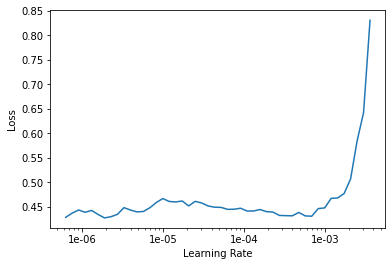

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr = 1e-04

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375565,0.323300,0.912129,05:55
1,0.360715,0.307881,0.915005,05:53
2,0.340803,0.289916,0.918283,05:52
3,0.336450,0.286549,0.919183,05:52
4,0.304785,0.284482,0.919119,05:52
5,0.307678,0.297503,0.918421,05:52
6,0.289710,0.323852,0.912038,05:52
7,0.293812,0.283564,0.917870,05:52
8,0.266200,0.281419,0.920859,05:53
9,0.229301,0.254194,0.928985,05:52


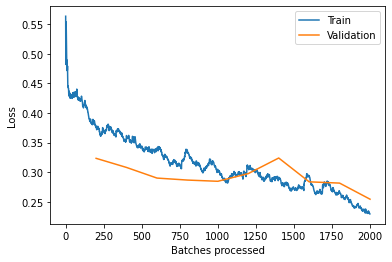

In [40]:
learn.recorder.plot_losses()

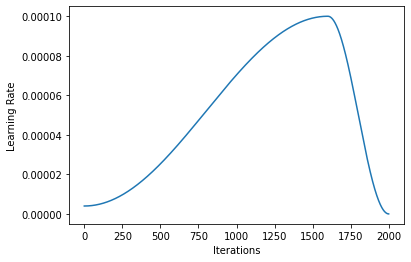

In [41]:
learn.recorder.plot_lr()

In [42]:
learn.save('stage-2-big')